In [1]:
#1. Install the necessary libraries
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install jiwer
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [2]:
# Import the necessary libraries
import transformers
import datasets
import accelerate
import evaluate
import jiwer
import os
import requests
from datasets import load_dataset
from transformers import AutoProcessor
from evaluate import load
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
from PIL import Image

In [3]:
#2. Prepare and Preprocess Dataset:
#a. Load the dataset
dataset = load_dataset("lambdalabs/pokemon-blip-captions")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [4]:
#b. Split the data into training and test
from  datasets import Dataset
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
# ***Part 2*** Select only the first 400 examples for the training dataset
train_dataset = Dataset.from_dict(dataset["train"][:400])
test_dataset = dataset["test"]

In [5]:
# To define processor
model_checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(model_checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [6]:
#c. Define the transform function

def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs

# Apply the transform function to the datasets
train_dataset.set_transform(transforms)
test_dataset.set_transform(transforms)

In [7]:
#3. Evaluation Metrics:
#a. Use WER for evaluation metric
wer = load("wer")
#b. Compute the evaluation metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [8]:
# Initialize the model
model = AutoModelForCausalLM.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [9]:
device= "cuda"

In [10]:
#4. Training:
#a. Use Trainer to train and save the model


# Define TrainingArguments
training_args = TrainingArguments(
    output_dir='./training_output', # Directory where the model predictions and checkpoints will be written
    learning_rate=5e-5,
    num_train_epochs=10,            # Total number of training epochs
    fp16=True,                      # Enable mixed precision training
    per_device_train_batch_size=8,  # Batch size per device during training, Adjust based on GPU memory
    per_device_eval_batch_size=8,   # Batch size for evaluation
    gradient_accumulation_steps=2,  # Implement gradient accumulation
    save_total_limit=3,             # Limit the total amount of checkpoints; conserves disk space
    save_strategy="steps",
    save_steps=10,
    logging_steps=5,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    report_to="wandb",              # Enables logging to Weights & Biases
    run_name="run"                  # Specifying run name for clarity and tracking

)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
5,11.157600
10,9.199200
15,8.427700
20,7.893000
25,7.425700
30,6.970300
35,6.516600
40,6.052400
45,5.597200
50,5.144700


TrainOutput(global_step=250, training_loss=2.1797025910019876, metrics={'train_runtime': 362.4371, 'train_samples_per_second': 11.036, 'train_steps_per_second': 0.69, 'total_flos': 1870730551296000.0, 'train_loss': 2.1797025910019876, 'epoch': 10.0})

In [11]:
# Save the model
trainer.save_model("shahad-model-save-directory")

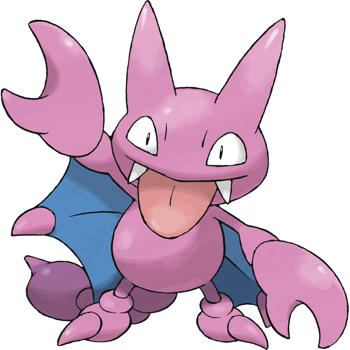

In [12]:
#5. Inference:
#a. Infer the caption for the following image
# Load the image
url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
display(image.resize((350,350)))

In [13]:
# Preprocess with the processor
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [14]:
# Perform inference
#b. For inference arguments, parameters: temperature=0.7, do_sample=True
generated_ids0 = model.generate(pixel_values=pixel_values, max_length=100, temperature=0.7, do_sample=True)
text = processor.decode(generated_ids0[0], skip_special_tokens=True)
print(text)

a pink and blue toy flying through the air


In [18]:
# Parameters: temperature=0.0, do_sample=False, I tried to used True but it dose not work
generated_ids1 = model.generate(pixel_values=pixel_values, max_length=100, temperature=0.0, do_sample=False)
text = processor.decode(generated_ids1[0], skip_special_tokens=True)
print(text)

a pink cartoon character with a pink nose


In [16]:
# Parameters: temperature=1.0, do_sample=True
generated_ids2 = model.generate(pixel_values=pixel_values, max_length=100, temperature=1.0, do_sample=True)
text = processor.decode(generated_ids2[0], skip_special_tokens=True)
print(text)

a drawing of a purple butterfly with yellow eyes
